# Processing Sequence using RNN and CNN

In [3]:
from pathlib import Path
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

def cls():
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)

2.6.0


In [4]:
# Lets download Ridership data
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)


'.\\datasets\\ridership.tgz'

In [5]:
# Do some preprocessing
path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


In [6]:
df.day_type.value_counts()

W    5336
U    1216
A    1087
Name: day_type, dtype: int64

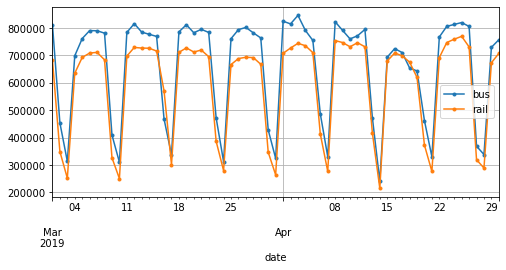

In [7]:
# Lets plot some month of 2019
df["2019-03":"2019-04"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

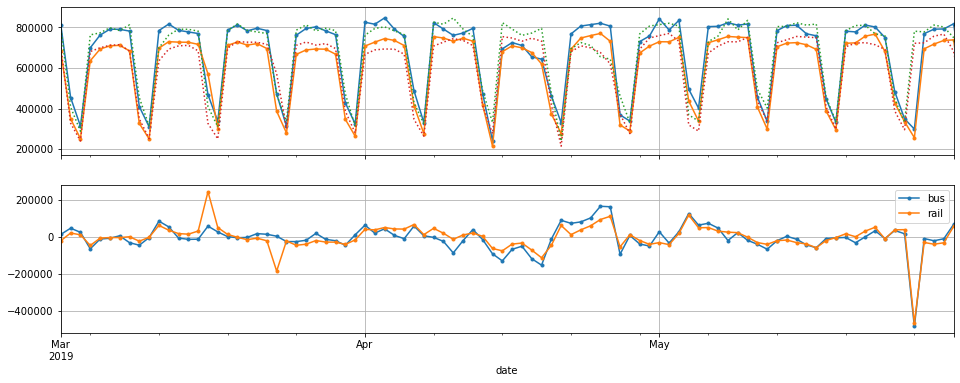

In [8]:
# To remove weekly trend
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"] # Difference of current value and its next 7th value

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(16, 6))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # 7 day lagged value

diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
plt.show()

In [9]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

In [10]:
# MAPE of two series
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

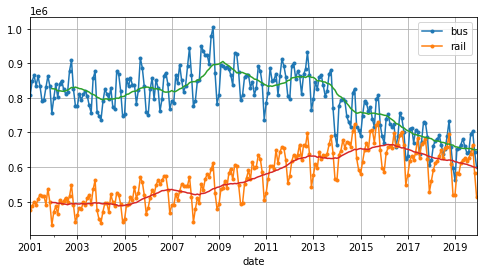

In [11]:
#Lets look at the yearly seasonality and the long term trends.

period = slice("2001", "2019")
df_monthly = df.resample('M').mean()  # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()
# Green and Red is normalized or 12 month moving average value

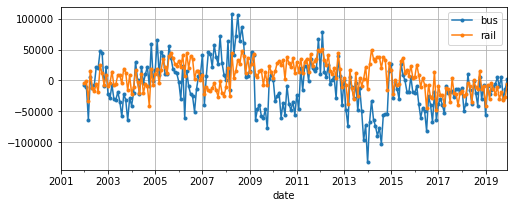

In [12]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show()

In [13]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()
y_pred

2019-06-01    427758.626282
Freq: D, dtype: float64

In [14]:
df["rail"].loc["2019-06-01"]  # target value

379044

In [15]:
df["rail"].loc["2019-05-25"]  # naive forecast (value from one week earlier)

426932

In [16]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()
mae  

32040.720093289623

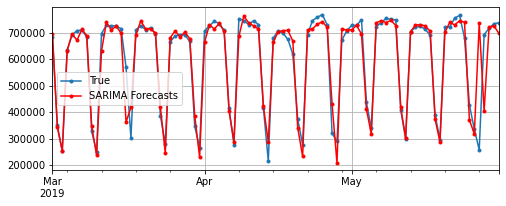

In [17]:
# Display the SARIMA forecast
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

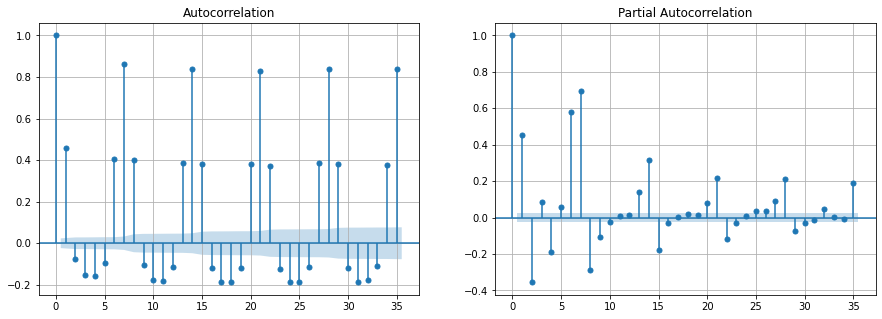

In [18]:
# Plotting the Autocorrelation Function (ACF) and the
# Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

In [19]:
########################################
# Create empty series using tensorflow #
########################################

# Here we first store the series value in array or list
my_series = [0, 1, 2, 3, 4, 5, 6]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2,
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[2, 3, 4],
         [3, 4, 5]])>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([5, 6])>)]

In [20]:
# Same series using tf.data module
for window_dataset in tf.data.Dataset.range(7).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 6 
4 5 6 
5 6 
6 


In [21]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [22]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

dataset = to_windows(tf.data.Dataset.range(7), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int64)>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4], dtype=int64)>),
 (<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[2, 3, 4],
         [3, 4, 5]], dtype=int64)>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([5, 6], dtype=int64)>)]

In [47]:
dataset = tf.data.Dataset.range(40)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.shuffle(20)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
dataset = dataset.batch(10).prefetch(1)
list(dataset.take(1))

[(<tf.Tensor: shape=(10, 4), dtype=int64, numpy=
  array([[ 4,  5,  6,  7],
         [ 5,  6,  7,  8],
         [20, 21, 22, 23],
         [ 9, 10, 11, 12],
         [17, 18, 19, 20],
         [ 0,  1,  2,  3],
         [ 8,  9, 10, 11],
         [ 7,  8,  9, 10],
         [18, 19, 20, 21],
         [25, 26, 27, 28]], dtype=int64)>,
  <tf.Tensor: shape=(10,), dtype=int64, numpy=array([ 8,  9, 24, 13, 21,  4, 12, 11, 22, 29], dtype=int64)>)]

In [48]:
# You can combine above operation into below funtion as well
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset


In [49]:
##################
# Data splitting #
##################

rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [50]:
rail_train.head() # univarient series,  3 years of data single value for 1 day ==> 365*3 +1 = 1096

date
2016-01-01    0.319835
2016-01-02    0.365509
2016-01-03    0.287661
2016-01-04    0.703185
2016-01-05    0.727716
Name: rail, dtype: float64

In [51]:
seq_length = 56
cls()
# Sequence to vector kind of data formatting
# 56 sequence of values give 57th prediction.
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    shuffle=True,
    batch_size=32,
    seed=42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [52]:
list(train_ds)[0] # 32*56 => 32 batch 56 cotinuous sequence number

(<tf.Tensor: shape=(32, 56), dtype=float64, numpy=
 array([[0.739158, 0.749136, 0.742502, ..., 0.777158, 0.509314, 0.421479],
        [0.725712, 0.762858, 0.749991, ..., 0.376485, 0.732335, 0.741141],
        [0.770186, 0.764653, 0.78316 , ..., 0.493961, 0.307105, 0.26531 ],
        ...,
        [0.510071, 0.719617, 0.813161, ..., 0.764611, 0.760471, 0.359088],
        [0.464903, 0.351102, 0.76766 , ..., 0.770507, 0.773696, 0.779012],
        [0.733693, 0.77807 , 0.76038 , ..., 0.381042, 0.675484, 0.697126]])>,
 <tf.Tensor: shape=(32,), dtype=float64, numpy=
 array([0.347259, 0.74504 , 0.386058, 0.460892, 0.660176, 0.797545,
        0.755604, 0.755558, 0.393884, 0.770507, 0.712596, 0.741773,
        0.723334, 0.323758, 0.481961, 0.805398, 0.762707, 0.779493,
        0.71522 , 0.272268, 0.692183, 0.730669, 0.320982, 0.796878,
        0.328391, 0.731858, 0.748709, 0.702745, 0.796057, 0.285153,
        0.429256, 0.719511])>)

### 1. Simple Linear model

In [53]:
###########################################
# Lets first build a simple Linear model. #
###########################################
# Suppose these 56 are not sequence they are features: we try to fit a linear combination of these 56 features
cls()
seq_length = 56 # or we can define (None, 56)
model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=[seq_length])])

model.compile(loss=tf.keras.losses.Huber(), optimizer="adam", metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=4)
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

Epoch 1/4
33/33 [==============================] - 1s 9ms/step - loss: 0.0114 - mae: 0.1236 - val_loss: 0.0113 - val_mae: 0.1155
Epoch 2/4
33/33 [==============================] - 0s 5ms/step - loss: 0.0094 - mae: 0.1088 - val_loss: 0.0084 - val_mae: 0.1072
Epoch 3/4
33/33 [==============================] - 0s 4ms/step - loss: 0.0079 - mae: 0.0989 - val_loss: 0.0073 - val_mae: 0.0950
Epoch 4/4
3/3 [==============================] - 0s 2ms/step - loss: 0.0063 - mae: 0.0887


88688.26925754547

In [54]:
weights, bias = model.get_weights()
len(weights), len(bias) # Total 57 parameters

(56, 1)

### 2. Simple RNN model

In [210]:
###########################################
# Building the same model using RNN layer #
###########################################

#defines a utility function we'll reuse several time
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=4):
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs)
    valid_loss, valid_mae = model.evaluate(valid_set)
    return model, (valid_mae * 1e6)

cls()
model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]), # Axis -1 insert 1 at last position [32,56]--> [32,56,1]
    tf.keras.layers.SimpleRNN(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [70]:
model.get_weights()

[array([[0.5700599]], dtype=float32),
 array([[1.]], dtype=float32),
 array([0.], dtype=float32)]

In [71]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/4
33/33 [==============================] - 1s 15ms/step - loss: 0.0222 - mae: 0.1633 - val_loss: 0.0190 - val_mae: 0.1423
Epoch 2/4
33/33 [==============================] - 0s 9ms/step - loss: 0.0169 - mae: 0.1559 - val_loss: 0.0178 - val_mae: 0.1583
Epoch 3/4
33/33 [==============================] - 0s 10ms/step - loss: 0.0166 - mae: 0.1568 - val_loss: 0.0175 - val_mae: 0.1545
Epoch 4/4
3/3 [==============================] - 0s 4ms/step - loss: 0.0177 - mae: 0.1438


143795.8925962448

In [72]:
model.get_weights()

[array([[0.43398044]], dtype=float32),
 array([[0.83349496]], dtype=float32),
 array([-0.02445907], dtype=float32)]

3/3 [==============================] - 0s 4ms/step - loss: 0.0177 - mae: 0.1438


143795.8925962448

In [81]:
cls()
model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]), # Axis -1 insert 1 at last position [32,56]--> [32,56,1]
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/4
33/33 [==============================] - 1s 20ms/step - loss: 0.0663 - mae: 0.2609 - val_loss: 0.0135 - val_mae: 0.1178
Epoch 2/4
33/33 [==============================] - 0s 11ms/step - loss: 0.0090 - mae: 0.1075 - val_loss: 0.0049 - val_mae: 0.0855
Epoch 3/4
33/33 [==============================] - 0s 10ms/step - loss: 0.0053 - mae: 0.0742 - val_loss: 0.0032 - val_mae: 0.0621
Epoch 4/4
3/3 [==============================] - 0s 5ms/step - loss: 0.0031 - mae: 0.0599


59878.792613744736

### 3. Deep RNN

In [134]:
train_ds2 = train_ds.map(lambda x,y: (tf.expand_dims(x, axis=-1), tf.expand_dims(y, axis=-1)))
valid_ds2 = valid_ds.map(lambda x,y: (tf.expand_dims(x, axis=-1), tf.expand_dims(y, axis=-1)))

In [255]:
cls()
#############################################
# It is preferable to replace the last layer with Dense bcz
# 1. RNN learn the sequence pattern most with the previous hidden layers. So we can ignore RNN layer at last
# 2. RNN use tanh default means output would be -1 to 1. so if we need to use another activation function then dense will help.
############################################

# if you use return_sequence True in 2nd last layer then you get 
# output of all time step

univar_model = tf.keras.models.Sequential([
        tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
        tf.keras.layers.SimpleRNN(32),
        tf.keras.layers.Dense(1),
])
univar_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 32)          1088      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


In [256]:
univar_model, eval = fit_and_evaluate(univar_model, train_ds2, valid_ds2, learning_rate=0.02)
eval

Epoch 1/4
33/33 [==============================] - 1s 18ms/step - loss: 0.0307 - mae: 0.1796 - val_loss: 0.0049 - val_mae: 0.0773
Epoch 2/4
33/33 [==============================] - 0s 14ms/step - loss: 0.0070 - mae: 0.0873 - val_loss: 0.0032 - val_mae: 0.0626
Epoch 3/4
33/33 [==============================] - 0s 14ms/step - loss: 0.0056 - mae: 0.0744 - val_loss: 0.0037 - val_mae: 0.0654
Epoch 4/4
3/3 [==============================] - 0s 5ms/step - loss: 0.0024 - mae: 0.0505


50465.97495675087

In [257]:
univar_model.predict(rail_test[:56].values.reshape(1,-1,1))

array([[0.4168356]], dtype=float32)

### 4. MultiVarient Time Series

In [226]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [227]:
cls()
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [229]:
list(train_mulvar_ds.take(1))

[(<tf.Tensor: shape=(32, 56, 5), dtype=float64, numpy=
  array([[[0.769128, 0.739158, 0.      , 0.      , 1.      ],
          [0.782892, 0.749136, 0.      , 0.      , 1.      ],
          [0.762764, 0.742502, 0.      , 0.      , 1.      ],
          ...,
          [0.838151, 0.777158, 1.      , 0.      , 0.      ],
          [0.542836, 0.509314, 0.      , 1.      , 0.      ],
          [0.427194, 0.421479, 0.      , 1.      , 0.      ]],
  
         [[0.79516 , 0.725712, 0.      , 0.      , 1.      ],
          [0.855117, 0.762858, 0.      , 0.      , 1.      ],
          [0.865397, 0.749991, 1.      , 0.      , 0.      ],
          ...,
          [0.409732, 0.376485, 0.      , 0.      , 1.      ],
          [0.785035, 0.732335, 0.      , 0.      , 1.      ],
          [0.765854, 0.741141, 0.      , 0.      , 1.      ]],
  
         [[0.853379, 0.770186, 0.      , 0.      , 1.      ],
          [0.836999, 0.764653, 0.      , 0.      , 1.      ],
          [0.841086, 0.78316 , 0.      

In [248]:
cls()
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])
mulvar_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                1216      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________


In [249]:
model,eval = fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/4
33/33 [==============================] - 1s 13ms/step - loss: 0.0404 - mae: 0.1841 - val_loss: 0.0022 - val_mae: 0.0565
Epoch 2/4
33/33 [==============================] - 0s 9ms/step - loss: 0.0024 - mae: 0.0495 - val_loss: 9.5322e-04 - val_mae: 0.0328
Epoch 3/4
33/33 [==============================] - 0s 7ms/step - loss: 0.0017 - mae: 0.0398 - val_loss: 0.0011 - val_mae: 0.0371
Epoch 4/4
3/3 [==============================] - 0s 3ms/step - loss: 7.9195e-04 - mae: 0.0288


### 5. Multiple Series Forecasting

In [250]:
# build and train a multitask RNN that forecasts both bus and rail

cls()
seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

model,eval = fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

Epoch 1/4
33/33 [==============================] - 1s 11ms/step - loss: 0.0398 - mae: 0.1953 - val_loss: 0.0073 - val_mae: 0.0998
Epoch 2/4
33/33 [==============================] - 0s 8ms/step - loss: 0.0039 - mae: 0.0632 - val_loss: 0.0012 - val_mae: 0.0384
Epoch 3/4
33/33 [==============================] - 0s 9ms/step - loss: 0.0027 - mae: 0.0509 - val_loss: 0.0010 - val_mae: 0.0362
Epoch 4/4
3/3 [==============================] - 0s 5ms/step - loss: 0.0018 - mae: 0.0491


In [252]:
# evaluates the naive forecasts for bus
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

43441.63157894737

In [253]:
#evaluates the multitask RNN's forecasts both bus and rail
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * tf.keras.metrics.mean_absolute_error(
        mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
    print(name, int(mae))

bus 41091
rail 57035


### 6. Forecasting Several Step Aheads

In [262]:
##############################################
# Method-1: Get forecast in loop with same   #
# trained model                              #
##############################################
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
print(X.shape)
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

(1, 56, 1)


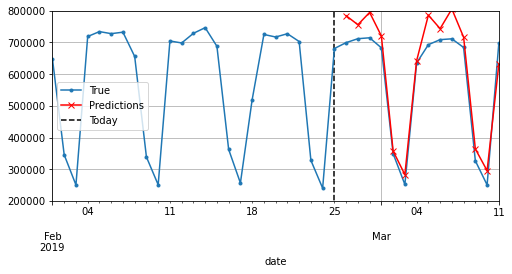

In [264]:
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
plt.show()

In [269]:
##############################################
# Method-2: Train RNN to predict all values  #
##############################################

cls()

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [270]:
list(ahead_train_ds.take(1))

[(<tf.Tensor: shape=(32, 56, 5), dtype=float64, numpy=
  array([[[0.842332, 0.80725 , 0.      , 0.      , 1.      ],
          [0.71526 , 0.721083, 1.      , 0.      , 0.      ],
          [0.500583, 0.474411, 0.      , 1.      , 0.      ],
          ...,
          [0.371865, 0.314798, 0.      , 0.      , 1.      ],
          [0.690503, 0.65065 , 0.      , 0.      , 1.      ],
          [0.636491, 0.63997 , 0.      , 0.      , 1.      ]],
  
         [[0.862939, 0.775439, 0.      , 0.      , 1.      ],
          [0.881225, 0.797235, 0.      , 0.      , 1.      ],
          [0.884662, 0.80132 , 0.      , 0.      , 1.      ],
          ...,
          [0.5918  , 0.600277, 1.      , 0.      , 0.      ],
          [0.362508, 0.319746, 0.      , 1.      , 0.      ],
          [0.290096, 0.24406 , 0.      , 0.      , 1.      ]],
  
         [[0.855438, 0.772464, 0.      , 0.      , 1.      ],
          [0.834308, 0.75616 , 1.      , 0.      , 0.      ],
          [0.513934, 0.460385, 0.      

In [271]:
cls()

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])
ahead_model, eval = fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Epoch 1/4
33/33 [==============================] - 1s 11ms/step - loss: 0.1265 - mae: 0.3815 - val_loss: 0.0280 - val_mae: 0.1914
Epoch 2/4
33/33 [==============================] - 0s 9ms/step - loss: 0.0192 - mae: 0.1611 - val_loss: 0.0134 - val_mae: 0.1287
Epoch 3/4
33/33 [==============================] - 0s 7ms/step - loss: 0.0130 - mae: 0.1302 - val_loss: 0.0101 - val_mae: 0.1116
Epoch 4/4
3/3 [==============================] - 0s 3ms/step - loss: 0.0084 - mae: 0.1018


In [283]:
X = mulvar_valid.to_numpy()[np.newaxis,:seq_length,:]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]
Y_pred

array([[0.79659045, 0.7166706 , 0.8159206 , 0.57156146, 0.54747766,
        0.50755036, 0.62186897, 0.63325125, 0.6331858 , 0.6815782 ,
        0.75562865, 0.45488584, 0.38609415, 0.6235176 ]], dtype=float32)

 
Sequence to sequence kind of architecture

Now let's create an RNN that predicts the next 14 steps at each time step. That is, instead of just forecasting time steps 56 to 69 based on time steps 0 to 55, it will forecast time steps 1 to 14 at time step 0, then time steps 2 to 15 at time step 1, and so on, and finally it will forecast time steps 56 to 69 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

To prepare the datasets, we can use to_windows() twice, to get sequences of consecutive windows, like this:

In [291]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]], dtype=int64)>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]], dtype=int64)>]

In [292]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]], dtype=int64)>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]], dtype=int64)>)]

In [293]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [294]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [296]:
list(seq2seq_train.take(1))

[(<tf.Tensor: shape=(32, 56, 5), dtype=float64, numpy=
  array([[[0.873275, 0.804156, 0.      , 0.      , 1.      ],
          [0.849532, 0.775198, 0.      , 0.      , 1.      ],
          [0.852594, 0.787476, 1.      , 0.      , 0.      ],
          ...,
          [0.415172, 0.376896, 0.      , 1.      , 0.      ],
          [0.393858, 0.410925, 0.      , 0.      , 1.      ],
          [0.769179, 0.735491, 0.      , 0.      , 1.      ]],
  
         [[0.898889, 0.774877, 0.      , 0.      , 1.      ],
          [0.85105 , 0.763128, 0.      , 0.      , 1.      ],
          [0.86767 , 0.786281, 0.      , 0.      , 1.      ],
          ...,
          [0.500775, 0.532343, 0.      , 1.      , 0.      ],
          [0.409978, 0.430982, 0.      , 1.      , 0.      ],
          [0.394914, 0.389143, 0.      , 0.      , 1.      ]],
  
         [[0.883059, 0.75475 , 1.      , 0.      , 0.      ],
          [0.503983, 0.421193, 0.      , 1.      , 0.      ],
          [0.39361 , 0.327173, 0.      

In [308]:
cls() 
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

seq2seq_model,eval = fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/4
33/33 [==============================] - 2s 32ms/step - loss: 0.0571 - mae: 0.2364 - val_loss: 0.0124 - val_mae: 0.1210
Epoch 2/4
33/33 [==============================] - 1s 22ms/step - loss: 0.0087 - mae: 0.0980 - val_loss: 0.0072 - val_mae: 0.0848
Epoch 3/4
33/33 [==============================] - 1s 24ms/step - loss: 0.0063 - mae: 0.0805 - val_loss: 0.0059 - val_mae: 0.0747
Epoch 4/4
3/3 [==============================] - 0s 11ms/step - loss: 0.0049 - mae: 0.0652


In [298]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]  # only the last time step's output
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

MAE for +1: 44,968
MAE for +2: 64,991
MAE for +3: 64,200
MAE for +4: 72,738
MAE for +5: 46,164
MAE for +6: 58,530
MAE for +7: 50,284
MAE for +8: 45,271
MAE for +9: 46,538
MAE for +10: 63,989
MAE for +11: 46,114
MAE for +12: 57,882
MAE for +13: 54,002
MAE for +14: 53,768


In [304]:
cls() 
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # This equivalent to: Dense(14) when previous layer return_sequence=True
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])
seq2seq_model,eval = fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/4
33/33 [==============================] - 2s 30ms/step - loss: 0.0573 - mae: 0.2366 - val_loss: 0.0128 - val_mae: 0.1219
Epoch 2/4
33/33 [==============================] - 1s 24ms/step - loss: 0.0087 - mae: 0.0980 - val_loss: 0.0070 - val_mae: 0.0828
Epoch 3/4
33/33 [==============================] - 1s 23ms/step - loss: 0.0062 - mae: 0.0788 - val_loss: 0.0053 - val_mae: 0.0695
Epoch 4/4
3/3 [==============================] - 0s 12ms/step - loss: 0.0051 - mae: 0.0675


### 7. Deal with Gradient Explode/Vanishing
Layer Norm

In [311]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [ ]:
# This is simple RNN but data will not directly feed to 
# activation layer it will first normalize

custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])
custom_ln_model,eval=fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

## Custom RNN Cell

In [313]:
class MyRNN(tf.keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences

    def get_initial_state(self, inputs):
        try:
            return self.cell.get_initial_state(inputs)
        except AttributeError:
            # fallback to zeros if self.cell has no get_initial_state() method
            batch_size = tf.shape(inputs)[0]
            return [tf.zeros([batch_size, self.cell.state_size],
                             dtype=inputs.dtype)]

    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size],
                           dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)

        if self.return_sequences:
            # stack the outputs into an array of shape
            # [time steps, batch size, dims], then transpose it to shape
            # [batch size, time steps, dims]
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

Note that `@tf.function` requires the `outputs` variable to be created before the `for` loop, which is why we initialize its value to a zero tensor, even though we don't use that value at all. Once the function is converted to a graph, this unused value will be pruned from the graph, so it doesn't impact performance. Similarly, `@tf.function` requires the `sequences` variable to be created before the `if` statement where it is used, even if `self.return_sequences` is `False`, so we create a `TensorArray` of size 0 in this case.

In [316]:
cls()

custom_model = tf.keras.Sequential([
    MyRNN(LNSimpleRNNCell(32), return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])
custom_model,eval=fit_and_evaluate(custom_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 2s 39ms/step - loss: 0.0804 - mae: 0.2886 - val_loss: 0.0178 - val_mae: 0.1508
Epoch 2/5
33/33 [==============================] - 1s 32ms/step - loss: 0.0149 - mae: 0.1434 - val_loss: 0.0156 - val_mae: 0.1243
Epoch 3/5
33/33 [==============================] - 1s 31ms/step - loss: 0.0119 - mae: 0.1276 - val_loss: 0.0130 - val_mae: 0.1155
Epoch 4/5
33/33 [==============================] - 1s 32ms/step - loss: 0.0104 - mae: 0.1155 - val_loss: 0.0111 - val_mae: 0.1075
Epoch 5/5
3/3 [==============================] - 0s 12ms/step - loss: 0.0103 - mae: 0.1024


### 8. LSTM Layers

In [317]:
cls()
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 3s 37ms/step - loss: 0.0535 - mae: 0.2516 - val_loss: 0.0187 - val_mae: 0.1723
Epoch 2/5
33/33 [==============================] - 1s 25ms/step - loss: 0.0176 - mae: 0.1599 - val_loss: 0.0176 - val_mae: 0.1480
Epoch 3/5
33/33 [==============================] - 1s 23ms/step - loss: 0.0160 - mae: 0.1532 - val_loss: 0.0169 - val_mae: 0.1422
Epoch 4/5
33/33 [==============================] - 1s 24ms/step - loss: 0.0152 - mae: 0.1484 - val_loss: 0.0161 - val_mae: 0.1390
Epoch 5/5
3/3 [==============================] - 0s 16ms/step - loss: 0.0153 - mae: 0.1361


(<keras.engine.sequential.Sequential at 0x2904c32af70>, 136072.91877269745)

### 9. GRU Layer

In [318]:
cls()
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 3s 38ms/step - loss: 0.0512 - mae: 0.2476 - val_loss: 0.0165 - val_mae: 0.1540
Epoch 2/5
33/33 [==============================] - 1s 26ms/step - loss: 0.0144 - mae: 0.1382 - val_loss: 0.0137 - val_mae: 0.1269
Epoch 3/5
33/33 [==============================] - 1s 26ms/step - loss: 0.0118 - mae: 0.1253 - val_loss: 0.0122 - val_mae: 0.1166
Epoch 4/5
33/33 [==============================] - 1s 27ms/step - loss: 0.0106 - mae: 0.1166 - val_loss: 0.0112 - val_mae: 0.1108
Epoch 5/5
3/3 [==============================] - 0s 12ms/step - loss: 0.0105 - mae: 0.1072


(<keras.engine.sequential.Sequential at 0x29050a712e0>, 107242.13719367981)

### 10. Conv1D Layer

In [340]:
#   |-----0-----|      |-----3----|      |--... |-------52------|
#           |-----1----|      |-----4----|   ... |       |-------53------|
#                 |-----2----|     |------5--...-51------|       |-------54------|
# X:  0  1  2  3  4  5  6  7  8  9 10 11 12 ...  104 105 106 107 108 109 110 111
# Y:      from 4     6     8    10    12    ...      106     108     110     112
#          to 17    19    21    23    25    ...      119     121     123     125

In [323]:
cls()
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])
conv_rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          672       
_________________________________________________________________
gru (GRU)                    (None, None, 32)          6336      
_________________________________________________________________
dense (Dense)                (None, None, 14)          462       
Total params: 7,470
Trainable params: 7,470
Non-trainable params: 0
_________________________________________________________________


In [338]:
##################
# Data preparing #
##################

def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)


longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112, shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
# cropping the first 3 value of target bcz kernel is 4 
# it will use first 4 values in calculation part
# also downsampling by 2 bcz stride is 2 which half the input
# sequence so we have to downsample the target as well
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

In [339]:
list(downsampled_train.take(1))

[(<tf.Tensor: shape=(32, 112, 5), dtype=float64, numpy=
  array([[[0.873275, 0.804156, 0.      , 0.      , 1.      ],
          [0.849532, 0.775198, 0.      , 0.      , 1.      ],
          [0.852594, 0.787476, 1.      , 0.      , 0.      ],
          ...,
          [0.395954, 0.343853, 0.      , 0.      , 1.      ],
          [0.7814  , 0.750329, 0.      , 0.      , 1.      ],
          [0.791868, 0.76722 , 0.      , 0.      , 1.      ]],
  
         [[0.898889, 0.774877, 0.      , 0.      , 1.      ],
          [0.85105 , 0.763128, 0.      , 0.      , 1.      ],
          [0.86767 , 0.786281, 0.      , 0.      , 1.      ],
          ...,
          [0.472199, 0.457178, 0.      , 1.      , 0.      ],
          [0.370394, 0.346616, 0.      , 0.      , 1.      ],
          [0.75786 , 0.744827, 0.      , 0.      , 1.      ]],
  
         [[0.883059, 0.75475 , 1.      , 0.      , 0.      ],
          [0.503983, 0.421193, 0.      , 1.      , 0.      ],
          [0.39361 , 0.327173, 0.     

In [331]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 3s 36ms/step - loss: 0.0482 - mae: 0.2420 - val_loss: 0.0214 - val_mae: 0.1616
Epoch 2/5
31/31 [==============================] - 1s 28ms/step - loss: 0.0165 - mae: 0.1532 - val_loss: 0.0171 - val_mae: 0.1423
Epoch 3/5
31/31 [==============================] - 2s 45ms/step - loss: 0.0144 - mae: 0.1447 - val_loss: 0.0157 - val_mae: 0.1342
Epoch 4/5
31/31 [==============================] - 2s 43ms/step - loss: 0.0130 - mae: 0.1361 - val_loss: 0.0141 - val_mae: 0.1254
Epoch 5/5
1/1 [==============================] - 0s 171ms/step - loss: 0.0124 - mae: 0.1159


(<keras.engine.sequential.Sequential at 0x290540c3580>, 115850.41135549545)

### 11. WaveNet

In [341]:
#  ⋮
# C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\...
#    \  /  \  /  \  /  \  /  \  /  \  /  \     
#      /    \      /    \      /    \          
# C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /...\
# X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 111
# Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 112
#  /14 15 16 17 18 19 20 21 22  23 24 25 26 ... 125

In [342]:
cls()
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=2, padding="causal", activation="relu", dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))
wavenet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          352       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          2

In [343]:
fit_and_evaluate(wavenet_model, longer_train, longer_valid, learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 2s 39ms/step - loss: 0.0794 - mae: 0.3161 - val_loss: 0.0239 - val_mae: 0.1726
Epoch 2/5
31/31 [==============================] - 1s 24ms/step - loss: 0.0173 - mae: 0.1586 - val_loss: 0.0182 - val_mae: 0.1558
Epoch 3/5
31/31 [==============================] - 1s 25ms/step - loss: 0.0160 - mae: 0.1567 - val_loss: 0.0182 - val_mae: 0.1523
Epoch 4/5
31/31 [==============================] - 1s 24ms/step - loss: 0.0157 - mae: 0.1548 - val_loss: 0.0179 - val_mae: 0.1511
Epoch 5/5
1/1 [==============================] - 0s 75ms/step - loss: 0.0176 - mae: 0.1477


(<keras.engine.sequential.Sequential at 0x29056250250>, 147692.9932832718)

The original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [344]:
class GatedActivationUnit(tf.keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = tf.keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [345]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = tf.keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal", dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = tf.keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return tf.keras.layers.Add()([z, inputs]), z

In [348]:
cls()

n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 32  # 128 in the paper
n_outputs = 14  # 256 in the paper

inputs = tf.keras.layers.Input(shape=[None, 5])
z = tf.keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)

z = tf.keras.activations.relu(tf.keras.layers.Add()(skip_to_last))
z = tf.keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_preds = tf.keras.layers.Conv1D(n_outputs, kernel_size=1)(z)

full_wavenet_model = tf.keras.Model(inputs=[inputs], outputs=[Y_preds])
full_wavenet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 32)     352         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 64)     4160        conv1d[0][0]                     
__________________________________________________________________________________________________
gated_activation_unit (GatedAct (None, None, 32)     0           conv1d_1[0][0]                   
______________________________________________________________________________________________

In [349]:
fit_and_evaluate(full_wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 2s 36ms/step - loss: 0.0707 - mae: 0.2865 - val_loss: 0.0208 - val_mae: 0.1629
Epoch 2/5
31/31 [==============================] - 1s 25ms/step - loss: 0.0138 - mae: 0.1399 - val_loss: 0.0141 - val_mae: 0.1269
Epoch 3/5
31/31 [==============================] - 1s 28ms/step - loss: 0.0104 - mae: 0.1191 - val_loss: 0.0115 - val_mae: 0.1124
Epoch 4/5
31/31 [==============================] - 1s 26ms/step - loss: 0.0086 - mae: 0.1050 - val_loss: 0.0100 - val_mae: 0.1031
Epoch 5/5
1/1 [==============================] - 0s 90ms/step - loss: 0.0084 - mae: 0.0942


(<keras.engine.functional.Functional at 0x2904b0a68b0>, 94164.97498750687)

In [ ]:
model = tf.keras.models.Sequential([
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast